### Simple Deep learning Model 

#### 1. Importing the necessary import

In [1]:
import os
from os import listdir
from os.path import isfile, join
from glob import glob

import random
import numpy as np
import pandas as pd
from tqdm import tqdm 

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

# from IPython.core.display import display, HTML
# from IPython.display import display
# display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# # %autoreload
# %load_ext autoreload

In [2]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Please install GPU version of TF")

2023-07-26 18:38:39.620568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:38:40.595680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-26 18:38:40.595855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PA

Default GPU Device:/device:GPU:0
Num GPUs Available:  1


2023-07-26 18:38:41.349038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:38:43.267715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:38:43.281890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 18:38:43.283602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 2. Loading the dataset

In [4]:
from sklearn.datasets import fetch_lfw_pairs

lfw_dataset_train = fetch_lfw_pairs(subset='train',color=True)
lfw_dataset_test = fetch_lfw_pairs(subset='test',color=True)

In [5]:
cnn_train_data = []
for images_paris in lfw_dataset_train['pairs']:
    image1 = images_paris[0]
    image2 = images_paris[1]
    # Stack the two images along the channel axis to create a single image 
    # with dimensions (32, 32, 6)
    combined_image = np.concatenate((image1, image2), axis=0)
    # combined_image = combined_image[:, :, :3]
    cnn_train_data.append(combined_image)
cnn_train_data  = np.stack(cnn_train_data, axis=0)


cnn_test_data = []
for images_paris in lfw_dataset_test['pairs']:
    image1 = images_paris[0]
    image2 = images_paris[1]
    # Stack the two images along the channel axis to create a single image 
    # with dimensions (32, 32, 6)
    combined_image = np.concatenate((image1, image2), axis=0)
    # combined_image = combined_image[:, :, :3]
    cnn_test_data.append(combined_image)
cnn_test_data  = np.stack(cnn_test_data, axis=0)

In [6]:
X_train = cnn_train_data
y_train = lfw_dataset_train['target']

In [7]:
X_test = cnn_test_data
y_test = lfw_dataset_test['target']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_test = label_as_binary.fit_transform(y_test)

In [28]:
from sklearn import preprocessing
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.fit_transform(y_test).toarray()

In [29]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

#### 3. Preparing the model 

In [30]:
def create_simple_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(3, 3))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(64, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)        
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

In [31]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

In [32]:
batch_size = 40

model_path = os.path.join("weights", "image_classification.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# train_gen = generator.get_batch(batch_size, is_augmented=True, validation=False)
# test_gen = generator.get_batch(400, is_augmented=False, validation=True)

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

# batch_img, _ = next(train_gen)
simple_model = create_simple_model((124,47,3), 2)
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
simple_model.summary()                                                                            

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 124, 47, 3)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 45, 32)       896       
                                                                 
 average_pooling2d_4 (Averag  (None, 40, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_8 (Batc  (None, 40, 15, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 40, 15, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 19200)             0   

#### 4. Running the model

In [40]:
with tf.device('/GPU:0'):
    history = simple_model.fit(
        X_train, y_train,
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=(X_test,y_test),
        epochs=100,
        verbose=1,
        callbacks=[reduceLROnPlato, checkPoint]
    )

Epoch 1/100
54/55 [============================>.] - ETA: 0s - loss: 0.5960 - accuracy: 0.6796
Epoch 1: val_loss did not improve from 0.69457
55/55 [==============================] - 3s 58ms/step - loss: 0.5956 - accuracy: 0.6800 - val_loss: 0.7461 - val_accuracy: 0.5140 - lr: 0.0025
Epoch 2/100
54/55 [============================>.] - ETA: 0s - loss: 0.5838 - accuracy: 0.6792
Epoch 2: val_loss did not improve from 0.69457
55/55 [==============================] - 3s 55ms/step - loss: 0.5829 - accuracy: 0.6800 - val_loss: 0.7565 - val_accuracy: 0.5250 - lr: 0.0025
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7064
Epoch 3: val_loss did not improve from 0.69457
55/55 [==============================] - 3s 55ms/step - loss: 0.5777 - accuracy: 0.7064 - val_loss: 1.5939 - val_accuracy: 0.5000 - lr: 0.0025
Epoch 4/100
54/55 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.6778
Epoch 4: val_loss did not improve from 0.69457
55/

#### 5. Evaluation

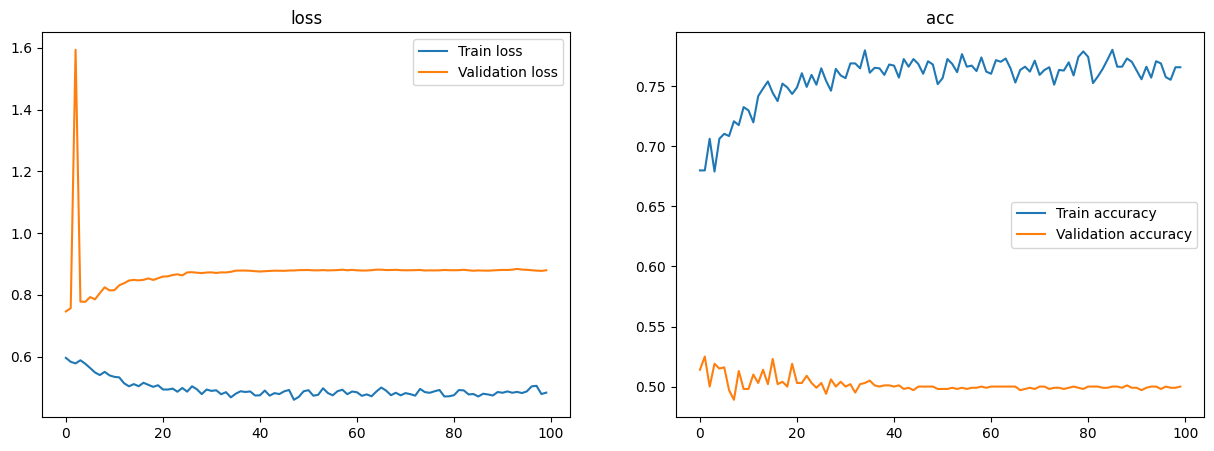

In [41]:
show_history(history)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

predict_idxs = simple_model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

y_test = label_as_binary.fit_transform(y_test)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

25/25 [==============================] - 0s 6ms/step
[[243 257]
 [243 257]]


In [43]:
target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names

In [44]:
target_names

array(['Different persons', 'Same person'], dtype='<U17')

In [45]:
print(classification_report(np.argmax(y_test, axis=1), predict_idxs, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.50      0.49      0.49       500
      Same person       0.50      0.51      0.51       500

         accuracy                           0.50      1000
        macro avg       0.50      0.50      0.50      1000
     weighted avg       0.50      0.50      0.50      1000

